<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/notebooks/04_Multi_class_Classification_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação Multiclasse


## 🎯 Objetivos


1. Entender quando e por que usar **one-hot encoding** em variáveis categóricas.
2. Treinar **Regressão Logística** para multiclasse com as estratégias **Um-contra-Todos (OvA)** e **Um-contra-Um (OvO)**.
3. Avaliar o desempenho do modelo com métricas apropriadas.


## 1. Importar bibliotecas


In [ ]:
# (opcional)
# !pip install numpy==2.2.0
# !pip install pandas==2.2.3
# !pip install scikit-learn==1.6.0
# !pip install matplotlib==3.9.3
# !pip install seaborn==0.13.2

In [1]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## 2. Sobre o dataset
O conjunto de dados usado neste laboratório é o **"Obesity Risk Prediction"**, disponível publicamente na <a href="https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition">UCI Machine Learning Repository</a> sob a licença <a href="https://creativecommons.org/licenses/by/4.0/legalcode">CC BY 4.0</a>. Ele possui **2.111 amostras** e **17 atributos** (features), além do alvo (classe) de obesidade.

Abaixo está um resumo conciso das variáveis (para a descrição completa, veja o link da UCI):

- **Demográficas/antropométricas:** `Gender`, `Age`, `Height`, `Weight`
- **Hábitos alimentares:** `FAVC`, `FCVC`, `NCP`, `CAEC`, `CH2O`, `CALC`
- **Estilo de vida/saúde:** `SMOKE`, `SCC`, `FAF`, `TUE`
- **Histórico/locomoção:** `family_history_with_overweight`, `MTRANS`
- **Alvo:** `NObeyesdad` (nível de obesidade)


### 2.1. Observação sobre as variáveis
Algumas colunas são **categóricas** (ex.: `Gender`, `MTRANS`, `CAEC`) e precisam virar números para o modelo. Vamos usar **one-hot encoding**.

As colunas numéricas contínuas (ex.: `Age`, `Height`, `Weight`) serão **padronizadas** (*standardization*) para facilitar o treinamento da regressão logística.


## 3. Carregar o dataset

In [2]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## 4. Análise Exploratória (EDA)


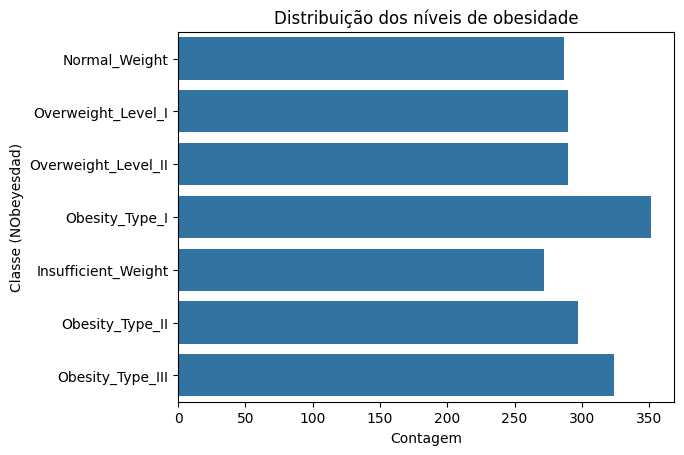

In [3]:
# Distribuição da variável-alvo (classes)
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribuição dos níveis de obesidade')
plt.xlabel('Contagem')
plt.ylabel('Classe (NObeyesdad)')
plt.show()


O gráfico sugere que as classes estão **razoavelmente balanceadas**, então (em princípio) não precisamos de técnicas especiais para lidar com forte desbalanceamento.


### Exercício 1
Verifique valores ausentes (*nulls*) e exiba um resumo do dataset (use `.info()` e `.describe()`).

In [4]:
# Checagem rápida de qualidade dos dados
print('Valores nulos por coluna:')
print(data.isnull().sum())

print('\nResumo do dataset (.info):')
print(data.info())

print('\nEstatísticas descritivas (.describe):')
print(data.describe())


Valores nulos por coluna:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Resumo do dataset (.info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                       

## 5. Pré-processamento dos dados


### 5.1. Escalonamento de features (padronização)
Vamos padronizar features numéricas contínuas para ficarem na mesma escala.


In [5]:
# 1) Padronização (standardization) de features numéricas contínuas
#    Fórmula: z = (x - média) / desvio-padrão
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Transformamos de volta em DataFrame (para manter nomes de colunas)
scaled_df = pd.DataFrame(
    scaled_features,
    columns=scaler.get_feature_names_out(continuous_columns)
)

# Substituímos as colunas originais pelas padronizadas
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)


**Por que padronizar?** A regressão logística usa uma função linear no espaço das features. Se uma feature tiver escala muito maior (ex.: `Weight`) do que outra, ela pode dominar o ajuste e atrapalhar a formação de boas fronteiras de decisão. A padronização ajuda o otimizador a convergir melhor.


### 5.2. One-hot encoding
Agora vamos transformar variáveis categóricas em colunas numéricas usando **one-hot encoding**.


In [6]:
# 2) One-hot encoding das colunas categóricas (exceto o alvo)
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # removemos a coluna-alvo

# drop='first' evita multicolinearidade perfeita (dummy trap)
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Conjunto final pronto (numérico)
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)


Após o one-hot encoding, cada categoria vira uma coluna (0/1). Isso aumenta o número total de colunas (features), o que é esperado.


### 5.3. Codificar a variável-alvo


In [7]:
# 3) Codificar o alvo (classe) como inteiro
# Importante: os códigos são uma representação numérica das classes.
# Guardamos um mapeamento para interpretar depois.
target_cat = prepped_data['NObeyesdad'].astype('category')
class_map = dict(enumerate(target_cat.cat.categories))  # {codigo: nome_da_classe}
prepped_data['NObeyesdad'] = target_cat.cat.codes

print('Mapeamento de classes (código -> classe):')
print(class_map)

prepped_data.head()


Mapeamento de classes (código -> classe):
{0: 'Insufficient_Weight', 1: 'Normal_Weight', 2: 'Obesity_Type_I', 3: 'Obesity_Type_II', 4: 'Obesity_Type_III', 5: 'Overweight_Level_I', 6: 'Overweight_Level_II'}


,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### 5.4. Separar features (X) e alvo (y)


In [8]:
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

## 6. Treinamento e avaliação do modelo


### 6.1. Separar treino e teste
Dividimos os dados em **treino** e **teste** para medir generalização em dados não vistos.


In [9]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 6.2. Regressão Logística com Um-contra-Todos (OvA)
Na abordagem **OvA**:

- Treinamos **um classificador binário por classe**.
- Cada classificador aprende: *“esta classe” vs “todas as outras”*.
- Se existem **k** classes, treinamos **k** modelos binários.


In [10]:
# Treino: Regressão Logística com estratégia OvA (One-vs-All)
# multi_class='ovr' => um-contra-todos; max_iter aumenta limite de iterações do otimizador
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)


LogisticRegression(max_iter=1000, multi_class='ovr')

Abaixo avaliamos a **acurácia** no conjunto de teste (uma métrica simples e comum).


In [11]:
# Predição e avaliação (OvA)
y_pred_ova = model_ova.predict(X_test)

print('Estratégia Um-contra-Todos (OvA)')
print(f"Acurácia: {np.round(100*accuracy_score(y_test, y_pred_ova), 2)}%")


Estratégia Um-contra-Todos (OvA)
Acurácia: 76.12%


### 6.3. Regressão Logística com Um-contra-Um (OvO)
Na abordagem **OvO**:

- Treinamos **um classificador binário para cada par de classes**.
- Se existem **k** classes, isso gera **k(k−1)/2** classificadores.
- Na predição, as classes “competem” entre si e decidimos a final por votação/score.


In [12]:
# Treino: Regressão Logística com estratégia OvO (One-vs-One)
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)


OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000))

Avalie a acurácia no teste (e compare com OvA).


In [13]:
# Predição e avaliação (OvO)
y_pred_ovo = model_ovo.predict(X_test)

print('Estratégia Um-contra-Um (OvO)')
print(f"Acurácia: {np.round(100*accuracy_score(y_test, y_pred_ovo), 2)}%")


Estratégia Um-contra-Um (OvO)
Acurácia: 92.2%


## 7. Exercícios


**Q1.** Experimente diferentes proporções de teste no `train_test_split` (ex.: `0.1`, `0.3`) e observe o impacto na acurácia.


In [14]:
# Q1 — efeito do tamanho do conjunto de teste
for test_size in [0.1, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    model_ova.fit(X_train, y_train)
    y_pred = model_ova.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size = {test_size:.1f} -> Acurácia = {acc:.4f}")


Test size = 0.1 -> Acurácia = 0.7594
Test size = 0.3 -> Acurácia = 0.7492


**Q2.** Faça um gráfico de “importância de features” usando os coeficientes do modelo OvA (e tente algo similar para o OvO).

> Importante: em regressão logística, “importância” aqui é apenas um **proxy** (média do valor absoluto dos coeficientes). Interprete com cuidado, principalmente quando há correlação entre features.


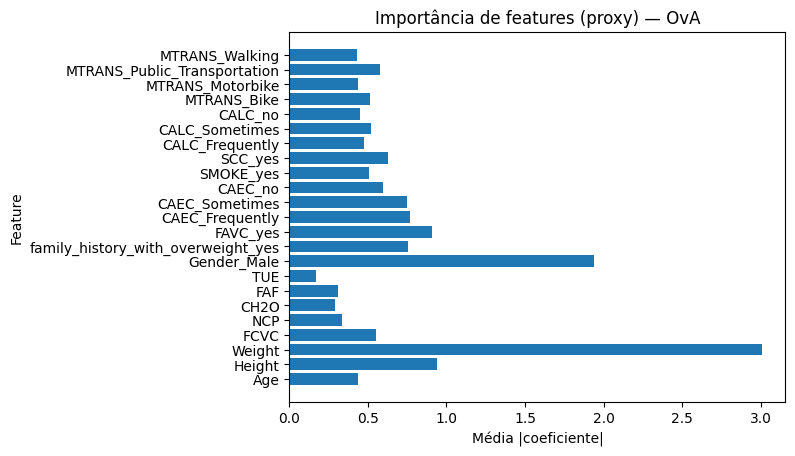

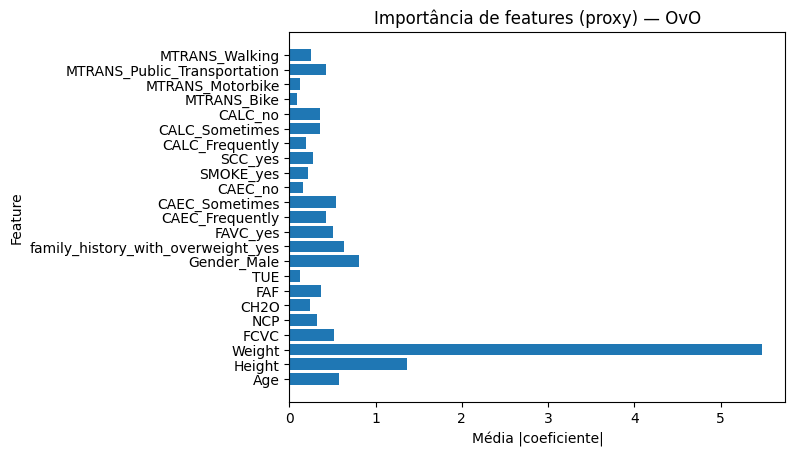

In [15]:
# Q2 — “importância” de features via magnitude dos coeficientes
# Para multiclasse (OvA), coef_ tem shape (n_classes, n_features)
feature_importance_ova = np.mean(np.abs(model_ova.coef_), axis=0)
plt.barh(X.columns, feature_importance_ova)
plt.title('Importância de features (proxy) — OvA')
plt.xlabel('Média |coeficiente|')
plt.ylabel('Feature')
plt.show()

# Para OvO: coletamos coeficientes de cada classificador binário
coefs = np.array([est.coef_[0] for est in model_ovo.estimators_])
feature_importance_ovo = np.mean(np.abs(coefs), axis=0)
plt.barh(X.columns, feature_importance_ovo)
plt.title('Importância de features (proxy) — OvO')
plt.xlabel('Média |coeficiente|')
plt.ylabel('Feature')
plt.show()


**Q3.** Crie uma função `obesity_risk_pipeline` para automatizar:
1) carregar + pré-processar, 2) treinar, 3) avaliar.


In [16]:
def obesity_risk_pipeline(data_path, test_size=0.2, random_state=42):
    """Pipeline enxuto: carrega, pré-processa, treina e avalia.

    Retorna:
        model: modelo treinado
        class_map: dict {codigo: nome_da_classe}
        acc: acurácia no teste
    """
    # 1) Carregar dados
    data = pd.read_csv(data_path)

    # 2) Padronizar numéricas contínuas
    continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[continuous_columns])
    scaled_df = pd.DataFrame(
        scaled_features,
        columns=scaler.get_feature_names_out(continuous_columns)
    )
    scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

    # 3) One-hot em categóricas (exceto o alvo)
    categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
    categorical_columns.remove('NObeyesdad')
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(scaled_data[categorical_columns])
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(categorical_columns)
    )
    prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

    # 4) Codificar alvo
    target_cat = prepped_data['NObeyesdad'].astype('category')
    class_map = dict(enumerate(target_cat.cat.categories))
    prepped_data['NObeyesdad'] = target_cat.cat.codes

    # 5) Separar X e y
    X = prepped_data.drop('NObeyesdad', axis=1)
    y = prepped_data['NObeyesdad']

    # 6) Treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 7) Treinar e avaliar (multiclasse)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return model, class_map, acc


# Exemplo de uso
model, class_map, acc = obesity_risk_pipeline(file_path, test_size=0.2)
print('Acurácia:', round(acc, 4))
print('Mapeamento de classes:', class_map)


Acurácia: 0.8794
Mapeamento de classes: {0: 'Insufficient_Weight', 1: 'Normal_Weight', 2: 'Obesity_Type_I', 3: 'Obesity_Type_II', 4: 'Obesity_Type_III', 5: 'Overweight_Level_I', 6: 'Overweight_Level_II'}
